In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from warnings import filterwarnings
filterwarnings('ignore')
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [2]:
with open('transformer.pkl', 'rb') as file:
    transformer = pickle.load(file)

with open('scaler.pkl', 'rb') as file:
    scaler = pickle.load(file)


In [3]:
data = pd.read_csv('../Data/cleaned/glass_cleaned.csv')

In [4]:
X = data.drop('Type', axis=1)
y = data['Type']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
X_train_scaled = scaler.transform(transformer.transform(X_train))
X_test_scaled = scaler.transform(transformer.transform(X_test))

In [7]:
param_grid_dtree = {
    'max_depth': [3, 5, 7],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [3, 5],
    'max_features': ['sqrt', 'log2']
}

dtree = DecisionTreeClassifier()

grid_search = GridSearchCV(dtree, param_grid_dtree, cv=5)
grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print('Best parameters:', best_params)



Best parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 5}


In [10]:
best_dtree = DecisionTreeClassifier(**best_params)
best_dtree.fit(X_train_scaled, y_train)

y_pred = best_dtree.predict(X_test_scaled)

#I'm using f1 score as I have class imbalance and accuracy to compare it later
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')

print('Accuracy:', accuracy)
print('F1 Score:', f1)


Accuracy: 0.7674418604651163
F1 Score: 0.7089285714285715


In [11]:
parameters_knn = {'n_neighbors': range(1, 21), 'weights': ['uniform', 'distance'], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

knn = KNeighborsClassifier()

grid_search = GridSearchCV(knn, parameters_knn, scoring='f1', cv=5)
grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print('Best parameters:', best_params)



Best parameters: {'algorithm': 'auto', 'n_neighbors': 1, 'weights': 'uniform'}


In [12]:
best_knn = KNeighborsClassifier(**best_params)
best_knn.fit(X_train_scaled, y_train)
y_pred = best_knn.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')

print('Accuracy:', accuracy)
print('F1 Score:', f1)

Accuracy: 0.7441860465116279
F1 Score: 0.6662497182781159


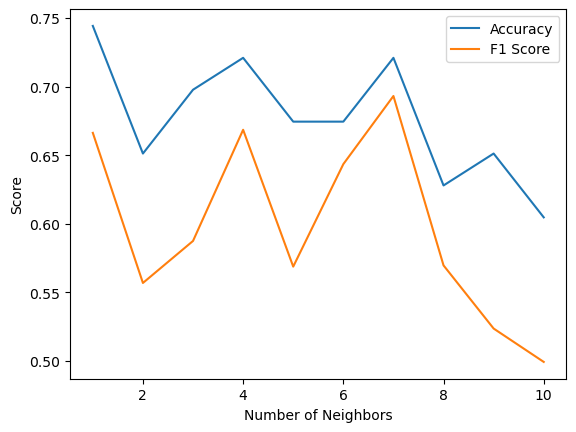

Best number of neighbors: 7


In [13]:
# Create a list of neighbors with possible values
neighbors = range(1, 11)

# Empty lists for storing the accuracy and f1 scores
accuracy_scores = []
f1_scores = []

for n in neighbors:
    knn = KNeighborsClassifier(n_neighbors=n)
    
    # Fit the model on the training data
    knn.fit(X_train_scaled, y_train)
    
    # Predict on the test data
    y_pred = knn.predict(X_test_scaled)
    
    # Calculate accuracy and f1-score
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)

# Plot the results
plt.plot(neighbors, accuracy_scores, label='Accuracy')
plt.plot(neighbors, f1_scores, label='F1 Score')
plt.xlabel('Number of Neighbors')
plt.ylabel('Score')
plt.legend()
plt.show()

# Best number of neighbors
best_neighbors = neighbors[f1_scores.index(max(f1_scores))]
print('Best number of neighbors:', best_neighbors)


In [14]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train_scaled, y_train)

print('Accuracy:', accuracy)
print('KNN F1:', knn.score(X_test_scaled, y_test))

Accuracy: 0.6046511627906976
KNN F1: 0.7209302325581395


In [15]:
param_grid_rf = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

# Create the Random Forest classifier
rf = RandomForestClassifier()

# Create the GridSearchCV object
grid_search = GridSearchCV(rf, param_grid_rf, scoring='f1_macro')

# Fit the model on the training data
grid_search.fit(X_train_scaled, y_train)

# Get the best parameter combination and score
best_params = grid_search.best_params_

print('Best parameter combination:', best_params)


Best parameter combination: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}


In [16]:
best_rf = RandomForestClassifier(**best_params)
best_rf.fit(X_train_scaled, y_train)
y_pred = best_rf.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')

print('Accuracy:', accuracy)
print('F1 Score', f1)

Accuracy: 0.8372093023255814
F1 Score 0.8374918540241122


In [17]:
parameters_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
}

mlp = MLPClassifier()

grid_search = GridSearchCV(mlp, parameters_mlp, cv=5)
grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_

print("Best Parameters:", best_params)


Best Parameters: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'solver': 'adam'}


In [18]:
best_mlp = MLPClassifier(**best_params)
best_mlp.fit(X_train_scaled, y_train)
y_pred = best_mlp.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')

print('Accuracy:', accuracy)
print('F1 Score', f1)

Accuracy: 0.7441860465116279
F1 Score 0.6654581529581529


Best F1 score was with Random Forest

In [19]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)


In [20]:
param_grid_rf = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

# Create the Random Forest classifier
rf = RandomForestClassifier()

# Create the GridSearchCV object
grid_search = GridSearchCV(rf, param_grid_rf, scoring='f1_macro')

# Fit the model on the training data
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best parameter combination and score
best_params = grid_search.best_params_

print('Best parameter combination:', best_params)


Best parameter combination: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}


In [21]:
best_rf = RandomForestClassifier(**best_params)
best_rf.fit(X_train_scaled, y_train)
y_pred = best_rf.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')

print('Accuracy:', accuracy)
print('F1 Score', f1)

Accuracy: 0.7674418604651163
F1 Score 0.7625000000000001


conclusion: the best model metric was with Random Forest without Smote